In [1]:
from IPython.core.display import display, HTML # for some notebook formatting.

import mlrose_hiive
import numpy as np
import logging
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


from ast import literal_eval
import chess

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import QueensGenerator, MaxKColorGenerator, TSPGenerator
from mlrose_hiive import SARunner, GARunner, MIMICRunner, RHCRunner

from util.utils import run_experiment_multi_seed, runner_results_to_stats, plot_fitness_iteration, get_optimal_hyperparameters
from util.utils import plot_fitness_vs_hyperparameter, plot_HP_heatmap, plot_fitness_fevals

# switch off the chatter
logging.basicConfig(level=logging.WARNING)


%load_ext autoreload
%autoreload 2

# Fixed random seed for reproducibility on random optimization problems
FIXED_SEED = 42
np.random.seed(FIXED_SEED)
# Random Seeds for reproducibility
RANDOM_SEEDS = [1, 2, 3, 4, 5]

/tmp/ipykernel_48801/3700617446.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML # for some notebook formatting.


# 1. Initialization of the problems
There will be three subproblems per RO problem with increasing difficulty. For *k*-Color, difficulty is increasing as the number of nodes, connections per node increases and k decreases.<br>
We define the subproblems as follows:
1. **Easy**: &emsp;&emsp;&ensp; $n_{nodes} = 20, max_{conn} = 2$
2. **Medium**:&emsp; $n_{nodes} = 30, max_{conn} = 3$
3. **Hard**: &emsp;&emsp;&ensp;$n_{nodes} = 50, max_{conn} = 4$

Note: The number of colors, *k*, depends on the graph structure and is not fixed. The minimum value of *k* for a graph to be *k*-colorable is the chromatic number of the graph, for which we can find a lower bound given by the size of the largest clique in the graph. We will use this lower bound as the initial value of *k* for the *k*-Color problem. Thus, the value of *k* for each subproblem will be: <br>

1. **Easy**: &emsp;&emsp;&ensp; $k = 3$
2. **Medium**:&emsp; $k = 4$
3. **Hard**: &emsp;&emsp;&ensp;$k = 5$

Each problem will be solved using the following algorithms:
1. **Hill Climbing with Random Restarts (RHC)**
2. **Simulated Annealing (SA)**
3. **Genetic Algorithm (GA)**
4. **MIMIC**

For each algorithm, we will run the random optimization algorithm with a set of random seeds to mitigate the effect of lucky and unlucky runs.

In [2]:
problem_easy = MaxKColorGenerator().generate(seed=FIXED_SEED, number_of_nodes=20, max_connections_per_node=2, max_colors=2, maximize=True)
problem_medium = MaxKColorGenerator().generate(seed=FIXED_SEED, number_of_nodes=30, max_connections_per_node=4, max_colors=3, maximize=True)
problem_hard = MaxKColorGenerator().generate(seed=FIXED_SEED, number_of_nodes=50, max_connections_per_node=10, max_colors=4, maximize=True)

# 2. Testing

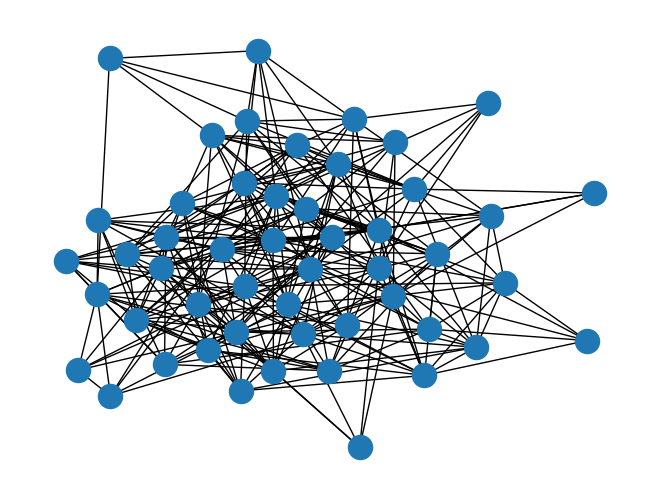

In [11]:
problem = problem_hard
nx.draw(problem.source_graph,
        pos=nx.spring_layout(problem.source_graph, seed = FIXED_SEED))
plt.show()

In [12]:
# Count the number of vertices in the graph
print(problem.source_graph.number_of_edges())

# Find the largest Clique in the graph
# Find all cliques in the graph
all_cliques = list(nx.find_cliques(problem.source_graph))

# Find the largest clique
largest_clique = max(all_cliques, key=len)

print("All cliques:", all_cliques)
print("Largest clique:", largest_clique)

271
All cliques: [[0, 34, 42], [0, 34, 3], [0, 34, 28], [0, 34, 37, 11], [0, 3, 31], [0, 35, 44], [0, 35, 28], [0, 5, 42, 15], [0, 5, 42, 31], [0, 5, 11, 10, 31], [0, 5, 11, 37], [0, 5, 11, 15], [0, 5, 44], [0, 38, 42], [0, 38, 28], [0, 41], [0, 43, 42, 31], [0, 43, 18, 44], [0, 46, 28], [0, 18, 11, 37], [0, 18, 11, 15], [1, 17, 10], [1, 17, 37], [1, 17, 6], [1, 10, 5], [1, 37, 5], [1, 22, 2, 16], [1, 22, 12, 6], [1, 22, 5], [2, 36, 33], [2, 36, 44, 22], [2, 36, 41], [2, 38], [2, 39, 14, 41], [2, 39, 14, 23], [2, 8, 44], [2, 7, 41], [2, 14, 44], [2, 16, 29], [4, 36, 44], [4, 36, 31], [4, 37], [4, 6], [4, 7, 48], [4, 7, 10], [4, 39, 27], [4, 39, 23], [4, 10, 31], [4, 48, 30], [4, 25], [4, 28, 30], [6, 40, 22], [6, 41, 12], [6, 11, 18, 15], [6, 15, 17], [7, 32, 13], [7, 34, 42], [7, 34, 11], [7, 5, 10, 11], [7, 5, 42, 13], [7, 5, 47], [7, 41, 48], [7, 41, 47], [7, 48, 42], [7, 18, 11], [8, 5, 15], [8, 5, 31, 24], [8, 5, 47, 24], [8, 5, 47, 44], [8, 9, 24], [8, 9, 20], [8, 9, 15], [8, 43,

In [51]:
rhc = RHCRunner(
                problem=problem_hard,
                experiment_name='rhc',
                output_directory=None,
                seed=FIXED_SEED,
                iteration_list= np.arange(0, 500, 10),
                restart_list=[0],
                max_attempts=50,
                )

rhc_results = run_experiment_multi_seed(rhc, RANDOM_SEEDS)

rhc_mean, rhc_std, rhc_min, rhc_max = runner_results_to_stats(rhc_results)

<Figure size 640x480 with 0 Axes>

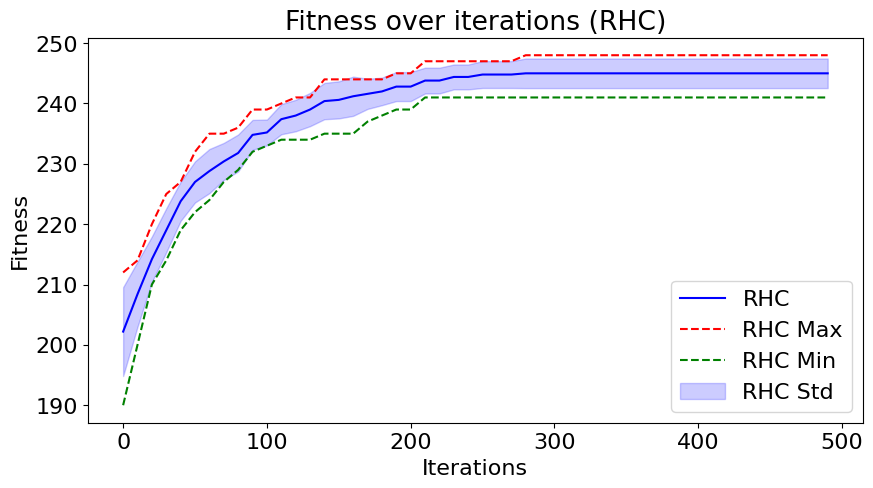

Best Fitness: 245.0


In [52]:
# plot the mean and std of the fitness with nice plots
plot_fitness_iteration(rhc_mean, rhc_std, rhc_min, rhc_max, "RHC", "TSP")
print(f'Best Fitness: {rhc_mean["Fitness"].max()}')

In [53]:
best_it = rhc_mean.iloc[rhc_mean['Fitness'].idxmax()]
best_it

Iteration                                                        280
Fitness                                                        245.0
FEvals                                                         267.2
Time                                                        0.069437
State              [1, 3, 0, 3, 1, 0, 0, 2, 2, 0, 3, 2, 1, 2, 1, ...
Restarts                                                           0
max_iters                                                        490
current_restart                                                    0
Name: 28, dtype: object

In [54]:
def show_k_color(problem, df_mean):
    best_it = df_mean.iloc[df_mean['Fitness'].idxmax()]
    color_indexes = literal_eval(best_it['State'])
    ordered_state = [color_indexes[n] for n in problem.source_graph.nodes]
    print(ordered_state)

    colors = ['lightcoral', 'lightgreen', 'lightblue', 'lightyellow', 'lightpink', 'lightgrey', 'lightcyan', 'lightseagreen', 'lightsalmon', 'lightsteelblue', 'lightgoldenrodyellow', 'lightseagreen']
    node_color_map = [colors[s] for s in ordered_state]

    nx.draw(problem.source_graph,
            pos=nx.spring_layout(problem.source_graph, seed = FIXED_SEED),
            with_labels=True,
            node_color=node_color_map)
    plt.show()

[1, 3, 0, 2, 3, 3, 3, 2, 3, 0, 0, 1, 1, 1, 3, 2, 2, 2, 2, 1, 0, 3, 0, 1, 2, 3, 0, 0, 0, 2, 3, 2, 1, 0, 2, 0, 3, 0, 3, 1, 2, 0, 2, 0, 3, 2, 3, 1, 1, 1]


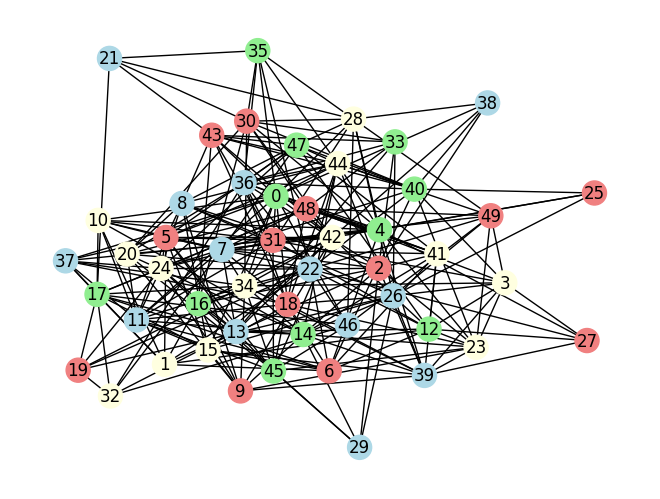

In [48]:
show_k_color(problem, rhc_mean)

# 3. Hyperparameter Tuning

## 3.1 SA

In [15]:
sa = SARunner(problem=problem_hard,
              experiment_name='sa',
              output_directory=None, # note: specify an output directory to have results saved to disk "experiments/TSP_SA_HP"
              seed=FIXED_SEED,
              iteration_list=np.arange(0, 1000, 10),
              max_attempts=100,
              temperature_list=[0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0],
              decay_list=[mlrose_hiive.ArithDecay, mlrose_hiive.ExpDecay, mlrose_hiive.GeomDecay])

sa_results = run_experiment_multi_seed(sa, RANDOM_SEEDS)

import pickle
with open('experiments/KC_SA_HP.pkl', 'wb') as f:
    pickle.dump(sa_results, f)


In [16]:
sa_hp_mean, sa_hp_std, sa_hp_min, sa_hp_max = runner_results_to_stats(sa_results)

In [17]:
best_it = get_optimal_hyperparameters(sa_hp_mean)
sa_optimal_HP = {}
sa_optimal_HP['schedule_init_temp'] = best_it['schedule_init_temp']
sa_optimal_HP['schedule_type'] = best_it['schedule_type']
sa_optimal_HP

{'schedule_init_temp': 1.0, 'schedule_type': 'geometric'}

schedule_type
schedule_init_temp = 0.5 Fitness: 255.6
schedule_init_temp = 1.0 Fitness: 257.0
schedule_init_temp = 2.0 Fitness: 256.8
schedule_init_temp = 3.0 Fitness: 256.0
schedule_init_temp = 5.0 Fitness: 255.4
schedule_init_temp = 10.0 Fitness: 256.2
schedule_init_temp = 20.0 Fitness: 256.0


<Figure size 640x480 with 0 Axes>

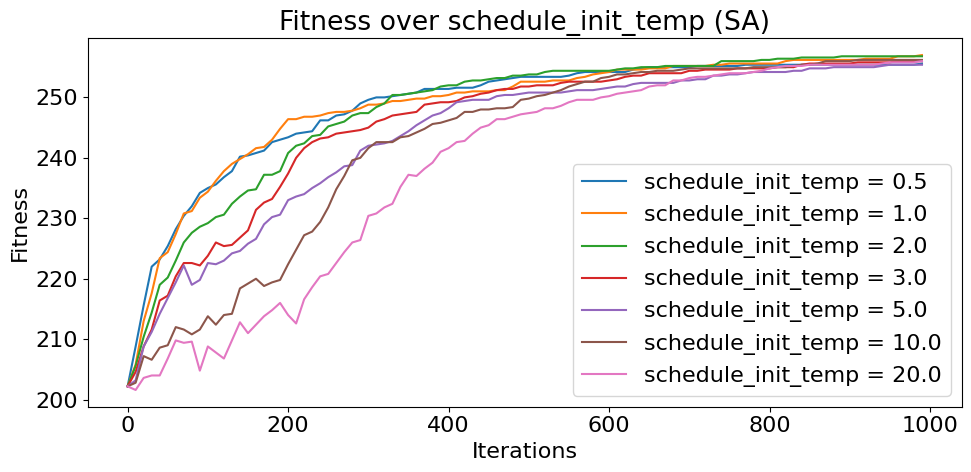

schedule_init_temp
schedule_type = arithmetic Fitness: 243.2
schedule_type = exponential Fitness: 254.4
schedule_type = geometric Fitness: 257.0


<Figure size 640x480 with 0 Axes>

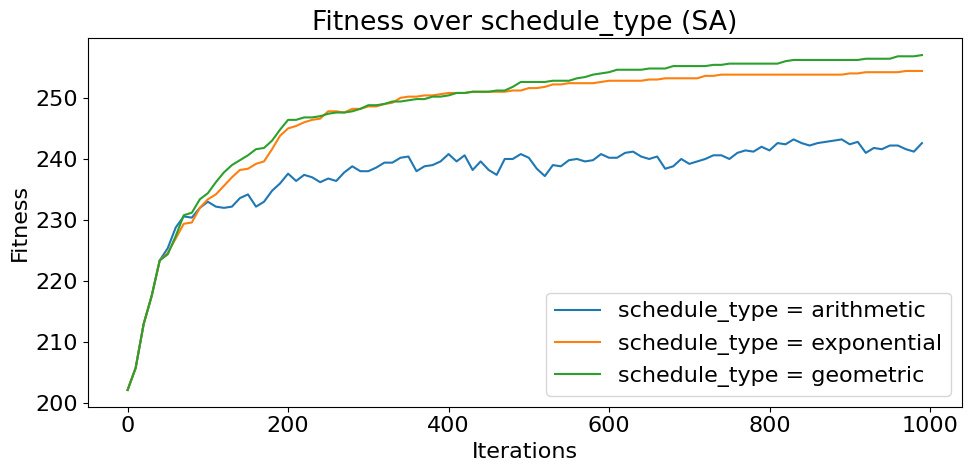

In [18]:
for key in sa_optimal_HP.keys():
    plot_fitness_vs_hyperparameter(sa_hp_mean, sa_hp_std, sa_optimal_HP, key, "SA", "TSP")

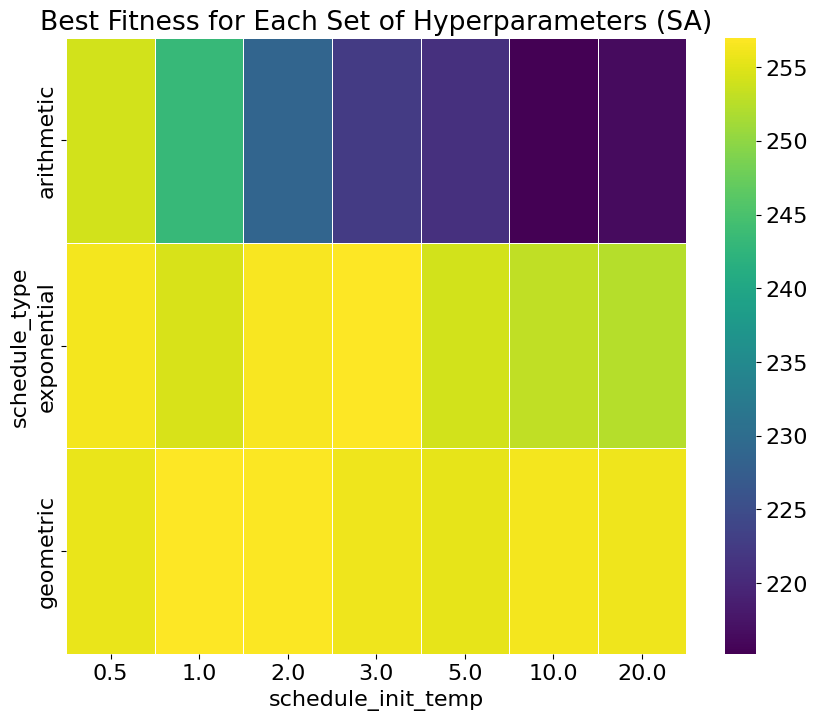

In [19]:
plot_HP_heatmap(sa_hp_mean, 'schedule_init_temp', 'schedule_type',  "SA", "TSP")

## 3.2 GA

In [24]:
ga = GARunner(problem=problem_hard,
              experiment_name='tsp_ga',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=FIXED_SEED,
              iteration_list=np.arange(0, 500, 10),
              max_attempts=50,
              population_sizes=np.arange(50, 500, 50),
              mutation_rates=[0.1, 0.3, 0.5, 0.7, 0.9]
            )

ga_results = run_experiment_multi_seed(ga, RANDOM_SEEDS)

In [25]:
import pickle
with open('experiments/KC_GA_HP.pkl', 'wb') as f:
    pickle.dump(ga_results, f)

In [4]:
import pickle
with open('experiments/KC_GA_HP.pkl', 'rb') as f:
    ga_results = pickle.load(f)

ga_hp_mean, ga_hp_std, ga_hp_min, ga_hp_max = runner_results_to_stats(ga_results)

best_it = get_optimal_hyperparameters(ga_hp_mean)
ga_optimal_HP = {}
ga_optimal_HP['Mutation Rate'] = best_it['Mutation Rate']
ga_optimal_HP['Population Size'] = best_it['Population Size']
ga_optimal_HP

{'Mutation Rate': 0.9, 'Population Size': 300}

<Figure size 640x480 with 0 Axes>

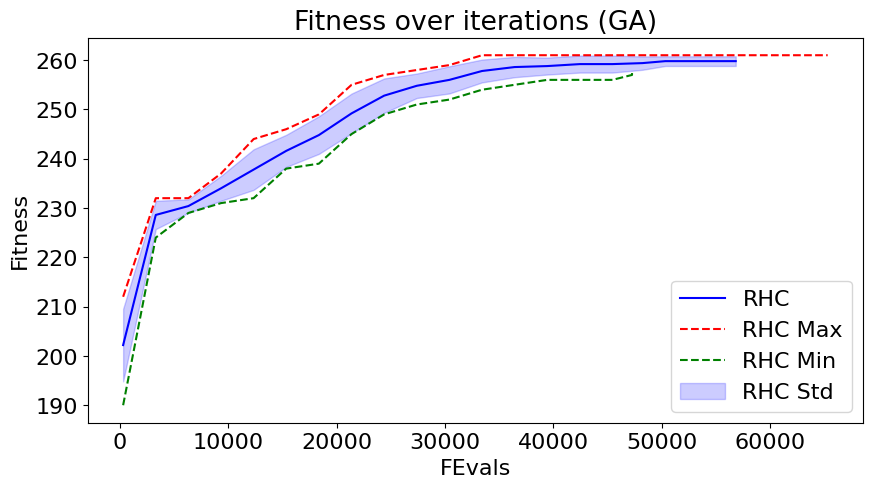

In [8]:
best_mean = ga_hp_mean[(ga_hp_mean['Population Size'] == ga_optimal_HP['Population Size']) & (ga_hp_mean['Mutation Rate'] == ga_optimal_HP['Mutation Rate'])]
best_std = ga_hp_std[(ga_hp_mean['Population Size'] == ga_optimal_HP['Population Size']) & (ga_hp_mean['Mutation Rate'] == ga_optimal_HP['Mutation Rate'])]
best_min = ga_hp_min[(ga_hp_mean['Population Size'] == ga_optimal_HP['Population Size']) & (ga_hp_mean['Mutation Rate'] == ga_optimal_HP['Mutation Rate'])]
best_max = ga_hp_max[(ga_hp_mean['Population Size'] == ga_optimal_HP['Population Size']) & (ga_hp_mean['Mutation Rate'] == ga_optimal_HP['Mutation Rate'])]
plot_fitness_fevals(best_mean, best_std, best_min, best_max, "GA", "TSP")

Population Size
Mutation Rate = 0.1 Fitness: 257.4
Mutation Rate = 0.3 Fitness: 256.4
Mutation Rate = 0.5 Fitness: 257.6
Mutation Rate = 0.7 Fitness: 258.6
Mutation Rate = 0.9 Fitness: 259.8


<Figure size 640x480 with 0 Axes>

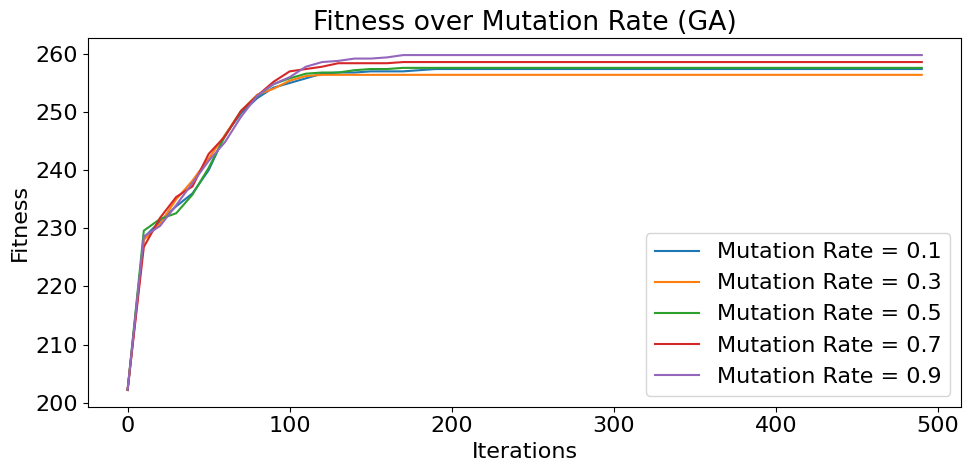

Mutation Rate
Population Size = 50 Fitness: 256.0
Population Size = 100 Fitness: 258.8
Population Size = 150 Fitness: 257.8
Population Size = 200 Fitness: 257.8
Population Size = 250 Fitness: 258.8
Population Size = 300 Fitness: 259.8
Population Size = 350 Fitness: 258.2
Population Size = 400 Fitness: 258.2
Population Size = 450 Fitness: 258.4


<Figure size 640x480 with 0 Axes>

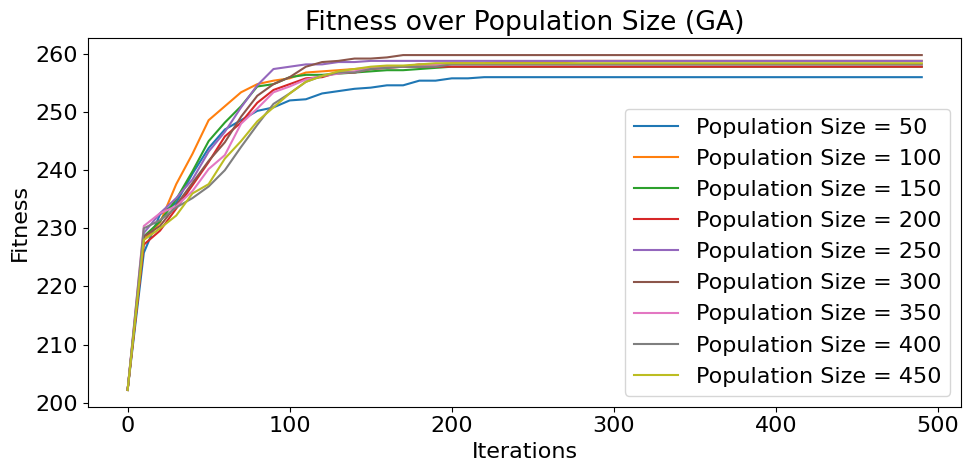

In [27]:
for key in ga_optimal_HP.keys():
    plot_fitness_vs_hyperparameter(ga_hp_mean, ga_hp_std, ga_optimal_HP, key, "GA", "TSP")

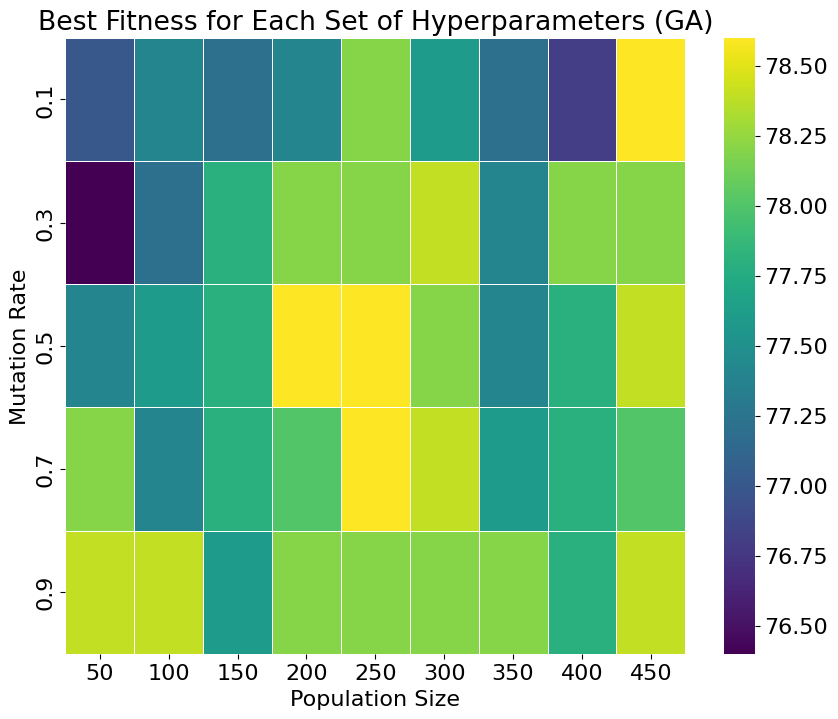

In [9]:
plot_HP_heatmap(ga_hp_mean, 'Population Size', 'Mutation Rate',  "GA", "TSP")

## 3.3 MIMIC

In [28]:
mmc = MIMICRunner(problem=problem_hard,
                    experiment_name='tsp_mimic',
                    output_directory=None, # note: specify an output directory to have results saved to disk
                    seed=FIXED_SEED,
                    iteration_list=np.arange(0, 100, 1),
                    max_attempts=5,
                    population_sizes=np.arange(50, 1000, 50),
                    keep_percent_list=[0.1, 0.3, 0.5, 0.7, 0.9],
                    use_fast_mimic=True
                    )

mmc_results = run_experiment_multi_seed(mmc, RANDOM_SEEDS)

import pickle
with open('experiments/KC_MIMIC_HP.pkl', 'wb') as f:
    pickle.dump(mmc_results, f)

In [29]:
import pickle
with open('experiments/KC_MIMIC_HP.pkl', 'rb') as f:
    mmc_results = pickle.load(f)

mmc_hp_mean, mmc_hp_std, mmc_hp_min, mmc_hp_max = runner_results_to_stats(mmc_results)

best_it = get_optimal_hyperparameters(mmc_hp_mean)
mmc_optimal_HP = {}
mmc_optimal_HP['Keep Percent'] = best_it['Keep Percent']
mmc_optimal_HP['Population Size'] = best_it['Population Size']
mmc_optimal_HP

{'Keep Percent': 0.3, 'Population Size': 800}

Population Size
Keep Percent = 0.1 Fitness: 253.0
Keep Percent = 0.3 Fitness: 256.0
Keep Percent = 0.5 Fitness: 236.2
Keep Percent = 0.7 Fitness: 228.0
Keep Percent = 0.9 Fitness: 227.4


<Figure size 640x480 with 0 Axes>

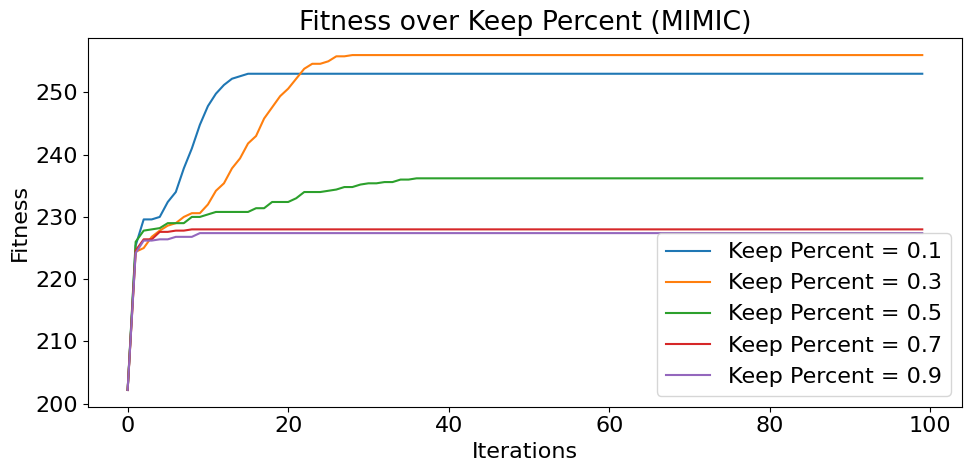

Keep Percent
Population Size = 50 Fitness: 231.4
Population Size = 100 Fitness: 240.0
Population Size = 150 Fitness: 243.0
Population Size = 200 Fitness: 239.4
Population Size = 250 Fitness: 249.2
Population Size = 300 Fitness: 242.0
Population Size = 350 Fitness: 253.0
Population Size = 400 Fitness: 246.8
Population Size = 450 Fitness: 251.2
Population Size = 500 Fitness: 252.6
Population Size = 550 Fitness: 243.4
Population Size = 600 Fitness: 249.4
Population Size = 650 Fitness: 248.2
Population Size = 700 Fitness: 249.8
Population Size = 750 Fitness: 249.0
Population Size = 800 Fitness: 256.0
Population Size = 850 Fitness: 235.2
Population Size = 900 Fitness: 246.8
Population Size = 950 Fitness: 240.0


<Figure size 640x480 with 0 Axes>

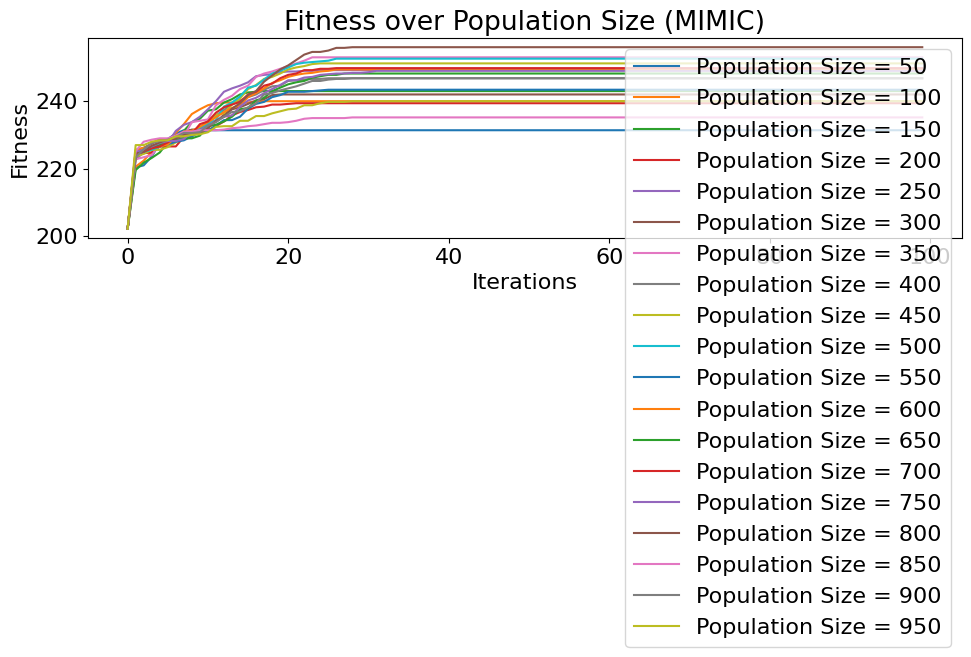

In [30]:
for key in mmc_optimal_HP.keys():
    plot_fitness_vs_hyperparameter(mmc_hp_mean, mmc_hp_std, mmc_optimal_HP, key, "MIMIC", "TSP")

In [21]:
mmc_opt = MIMICRunner(problem=problem_hard,
                    experiment_name='tsp_mimic',
                    output_directory=None, # note: specify an output directory to have results saved to disk
                    seed=FIXED_SEED,
                    iteration_list=np.arange(0, 500, 1),
                    max_attempts=30,
                    population_sizes=[800],
                    keep_percent_list=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                    use_fast_mimic=True
                    )

mmc_results_opt = run_experiment_multi_seed(mmc_opt, RANDOM_SEEDS)

mmc_opt_mean, mmc_opt_std, mmc_opt_min, mmc_opt_max = runner_results_to_stats(mmc_results_opt)

In [10]:
mmc_results_opt = mmc_opt.run()

100%|██████████| 9/9 [00:39<00:00,  4.40s/it]


In [15]:
mmc_results_opt = [mmc_results_opt]
mmc_opt_mean, mmc_opt_std, mmc_opt_min, mmc_opt_max = runner_results_to_stats(mmc_results_opt)

Best Fitness: 256.0


<Figure size 640x480 with 0 Axes>

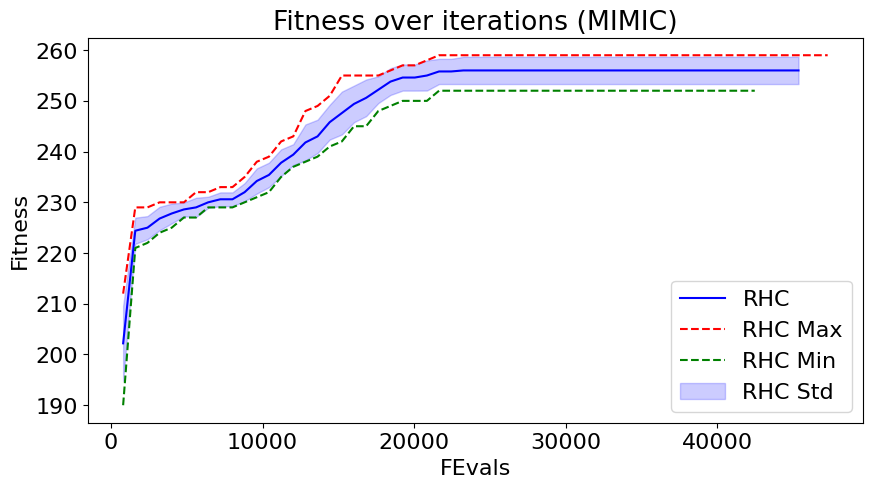

<Figure size 640x480 with 0 Axes>

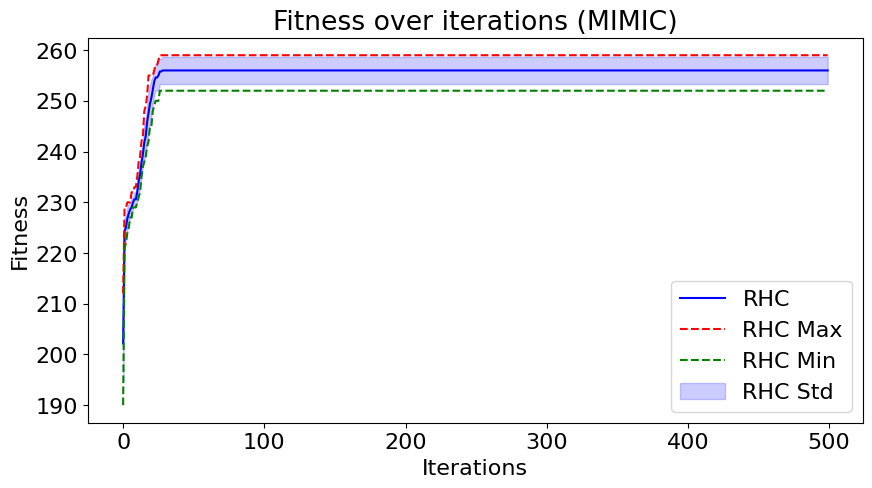

In [22]:
print(f'Best Fitness: {mmc_opt_mean["Fitness"].max()}')
best_it = mmc_opt_mean.iloc[mmc_opt_mean['Fitness'].idxmax()]
mmc_optimal_HP = {}
mmc_optimal_HP['Keep Percent'] = best_it['Keep Percent']
mmc_optimal_HP['Population Size'] = best_it['Population Size']
best_mean = mmc_opt_mean[(mmc_opt_mean['Population Size'] == mmc_optimal_HP['Population Size']) & (mmc_opt_mean['Keep Percent'] == mmc_optimal_HP['Keep Percent'])]
best_std = mmc_opt_std[(mmc_opt_mean['Population Size'] == mmc_optimal_HP['Population Size']) & (mmc_opt_mean['Keep Percent'] == mmc_optimal_HP['Keep Percent'])]
best_min = mmc_opt_min[(mmc_opt_mean['Population Size'] == mmc_optimal_HP['Population Size']) & (mmc_opt_mean['Keep Percent'] == mmc_optimal_HP['Keep Percent'])]
best_max = mmc_opt_max[(mmc_opt_mean['Population Size'] == mmc_optimal_HP['Population Size']) & (mmc_opt_mean['Keep Percent'] == mmc_optimal_HP['Keep Percent'])]
plot_fitness_fevals(best_mean, best_std, best_min, best_max, "MIMIC", "TSP")
plot_fitness_iteration(best_mean, best_std, best_min, best_max, "MIMIC", "TSP")